In [1]:
from ipynb.fs.full.Introduction import *
from tqdm import tqdm
import time

## Do Deeper Networks Solve the Problem?

If $\frac{|\lambda_{2}|}{|\lambda_{1}|}$ is large, then the summand in $d_{Katz}$, $(\alpha{}A)^{k}\vec{1}$,  requires $k>>0$ before converging to the dominant eigenvector, $v_{1}$,

$$d_{Katz} = \sum_{k=0}^{n} (\alpha{}A)^{k}\vec{1} + \vec{v_{1}}\sum_{k=n+1}^{\infty}\alpha{}^{k}$$

at which point the second term can be computed without further powers of $A$. As such, we posit that deeper GCNs are required to learn the Katz Centrality of low-density, high eigenvalue-ratio SBMs. 

### Model and Dataset Code

SBMs are the same as before, with $p\in{}[\frac{1}{50n},\frac{1}{n}]$. We still consider only the undirected, unweighted case.

In [2]:
num_graphs = 3000
d = []
for _ in range(num_graphs):
    # Set Cluster sizes and edge probabilities
    n = torch.randint(50,100,(5,))
    p = 1/(50*n) + (49/(50*n)) * torch.rand((5,5))
    p = .5 * (p + p.T)
    
    # Generate SBM
    x,edges = torch.ones((n.sum(),1)),torch_geometric.utils.remove_isolated_nodes(torch_geometric.utils.stochastic_blockmodel_graph(n,p))[0]
    adj = torch_sparse.SparseTensor(row=edges[0],col=edges[1])

    # Write to Data object
    d.append(torch_geometric.data.Data(x=x[:adj.size(0)],edge_index = edges))

for idx,G in enumerate(d):
    G.edge_weight = torch.ones(G.edge_index[0].shape)
    adj = torch_sparse.SparseTensor(row=G.edge_index[0],col=G.edge_index[1],value=G.edge_weight)
    
    # Compute Katz Centrality
    vals = torch.norm(torch.eig(adj.to_dense())[0],dim=1)
    v = 1/(1.01*vals.max())
    y = torch.sum(torch.inverse(torch.eye(adj.size(0)) - v*adj.to_dense().T) - torch.eye(adj.size(0)),dim=1)
    
    # Set as target
    G.y = y
    G.eig_max = vals.max()
    G.eig_min = vals.min()
    d[idx] = G
    
train,test = d[:2000],d[2000::]
train_loader = torch_geometric.data.DataLoader(train,batch_size=200,shuffle=True)
test_loader = torch_geometric.data.DataLoader(test,batch_size=200,shuffle=True)

KeyboardInterrupt: 

In [3]:
# Compute the Mean Average Distance of inputs
def batched_MAD(X,edge_index,edge_weights):
    X = X/torch.norm(X,dim=1)[:,None]
    cosine = 1 - torch.sum(X[edge_index[0]] * X[edge_index[1]],dim=1)
    return 1/edge_weights.sum() * (edge_weights * cosine).sum()

# Compute the Aggregation Norm
def batched_agg(X,edge_index,edge_weights,batch):
    nX = torch_scatter.scatter_sum(edge_weights[:,None] * X[edge_index[1]], edge_index[0],dim=0)
    X,nX = X/torch_scatter.scatter_sum(X**2,batch,dim=0).sqrt()[batch],\
              nX/torch_scatter.scatter_sum(nX**2,batch,dim=0).sqrt()[batch]
    return torch.norm(X - nX,dim=1).mean()

# Compute normalized (absolute) rayleigh quotient
def rayleigh_quotient(X,edge_index,edge_weights,batch,eig_max,eig_min):
    num = torch_scatter.scatter_sum(X * torch_scatter.scatter_sum(edge_weights[:,None] * 
                                        X[edge_index[1]], edge_index[0],dim=0),
                                        batch, dim=0)
    denom = torch_scatter.scatter_sum(X**2,batch,dim=0)
    R = num/(denom)
    return torch.mean((eig_max[:,None] - R.abs())/(eig_max - eig_min)[:,None])

In [22]:
graph_results = []
model_mad = []
model_agg = []
model_rayleigh = []

torch.manual_seed(0)
for k in [1,2,4,8,16,32,64]:
    graph = GraphConv(1,32,1,k).cuda()
    
    graph_results.append(train_loop(graph,train_loader,test_loader,150,lr=1e-1))
    torch.cuda.empty_cache()

    # Iterate through network layers and compute the MAD/Agg at each
    MAD,Agg,Ray = torch.zeros(k),torch.zeros(k),torch.zeros(k)
    
    for idx,data in enumerate(test_loader):
        X = data.x.cuda()
        row,col = data.edge_index[0].cuda(),data.edge_index[1].cuda()
        batch = data.batch.cuda()

        graph.eval()
        X = graph.start(X)
        
        for jdx,m in enumerate(graph.intermediate):
            X = X + m[0](X) + torch_scatter.scatter_sum(m[1](X)[col], row.cuda(),dim=0)
            X = torch.nn.LeakyReLU()(graph.bn[jdx](X))
            MAD[jdx] += batched_MAD(X,data.edge_index.cuda(),data.edge_weight.cuda()).mean().item()
            Agg[jdx] += batched_agg(X,data.edge_index.cuda(),data.edge_weight.cuda(),batch).item()
            Ray[jdx] += rayleigh_quotient(X,data.edge_index.cuda(),data.edge_weight.cuda(),
                                    batch,data.eig_max.cuda(),data.eig_min.cuda()).item()
        
    model_mad.append(MAD/(idx+1))
    model_agg.append(Agg/(idx+1))
    model_rayleigh.append(Ray/(idx+1))

### Results

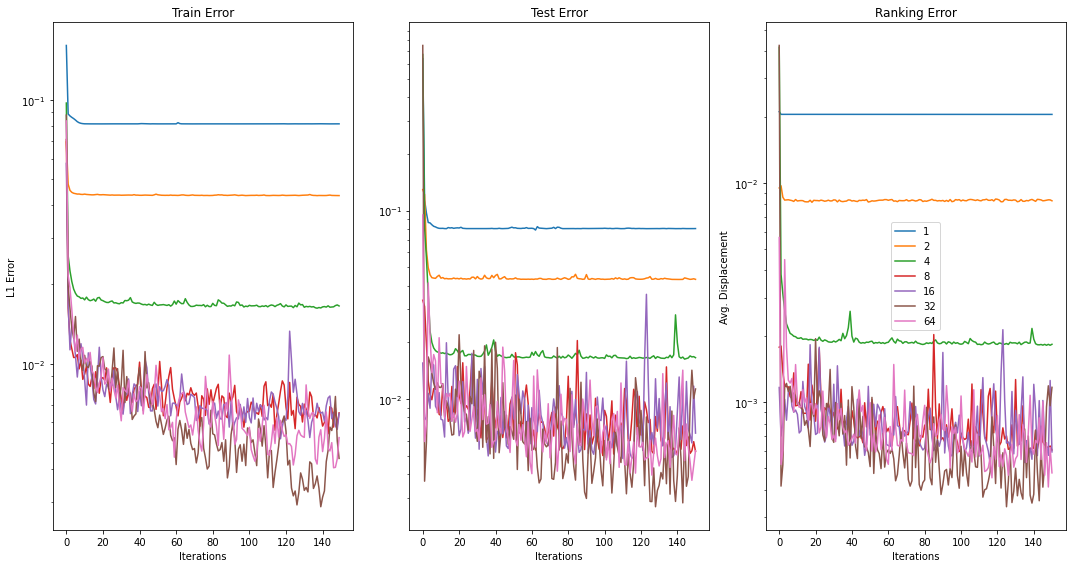

In [24]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
for i in range(7):
  plt.semilogy(graph_results[i][0])

plt.title('Train Error')
plt.ylabel('L1 Error')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
for i in range(7):
  plt.semilogy(graph_results[i][1])

plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
for idx,alpha in enumerate([1,2,4,8,16,32,64]):
  plt.semilogy(graph_results[idx][2],label=alpha)
plt.title('Ranking Error')
plt.ylabel('Avg. Displacement')
plt.xlabel('Iterations')
plt.legend()

plt.tight_layout();

We plot a) training loss b) test loss and c) average rank displacement for $l=2^{n}, n=0,1,...,6$. We also plot below the best values on the test loss versus number of trainable parameters. 

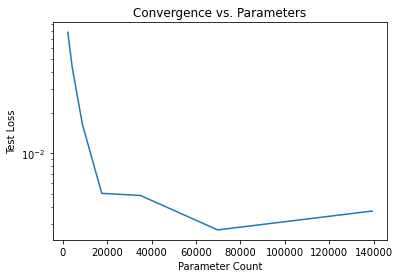

In [26]:
params = [2200,4200,8801,17505,34913,69729,139361]
plt.semilogy(params,[np.min(graph_results[i][1][-100:]) for i in range(7)])
plt.xlabel('Parameter Count')
plt.ylabel('Test Loss');
plt.title('Convergence vs. Parameters');

Increasing network depth to better performance. However, the loss begins to stagnate past $l=8$ relative to parameter count, and it is still nearly half an order of a magnitude worse than for the initial $p\in{}[\frac{1}{n},\frac{10}{n}]$ dataset. Side note: the test loss is already quite small for $l=32$ and $l=64$ when the model in completely untrained; perhaps some sort of resevoir computing would work well?

### Is This Oversmoothing?

GCNs suffer from a peculiar phenomena known as *oversmoothing*. In essence,  performance tends to degrade as you add more layers, and the features of each node converge to the same values. We choose to measure smoothing by the layerwise Mean Average Distance [14],

$$\frac{1}{\sum_{i,j\in{}E}w_{ij}}\sum_{i,j\in{}E}w_{ij}(1 - \frac{x_{j}^{T}x_{i}}{||x_{i}||_{2}||x_{j}||_{2}})$$

layer-wise Aggregation Norm,

$$\frac{1}{|V|}\sum_{i\in{}V}||\frac{\sum_{j\in{}N_{i}^{1}}w_{ij}x_{j}}{||\sum_{j\in{}N_{i}^{1}}w_{ij}x_{j}||_{2}} - \frac{x_{i}}{||x_{i}||_{2}}||_{2}$$

and the absolute Rayleigh Coefficient

$$\frac{1}{\lambda_{max}-\lambda_{min}}(\lambda_{max} - |\frac{\vec{x}A\vec{x}}{\vec{x}\cdot{}\vec{x}}|)$$

with MinMax normalization. AggNorm may be interpreted as a measure of how close the columns of $X^{l}$ are to eigenvectors of $A$. The Normalized Rayleigh Quotient is even more specific, with low values indicating greater similarity to dominant eigenvector $v_{1}$. 

Current theoretical analysis of oversmoothing has been focused on the GCNConv operator of Kipf and Welling [15].

$$X^{l+1} = (D^{\frac{-1}{2}}AD^{\frac{1}{2}})X^{l}W$$

This is a psuedo-spectral convolution, in it that aggregates using a form of the symmetric normalized graph Lapalcian $L_{sym} = I - D^{\frac{-1}{2}}AD^{\frac{1}{2}}$. The graph Laplacian in analogous to the discrete Laplacian operator in a Cartesian space; it diffuses material until it is distributed evenly across the network (or as much as is possible). This is the root of the overmsoothing problem in GCNConv. However, the literatures demonstrates that spatial convolution algorithms, which do not explicitly incorporate $L_{sym}$, are no less vulnerable to oversmoothing [14,16].



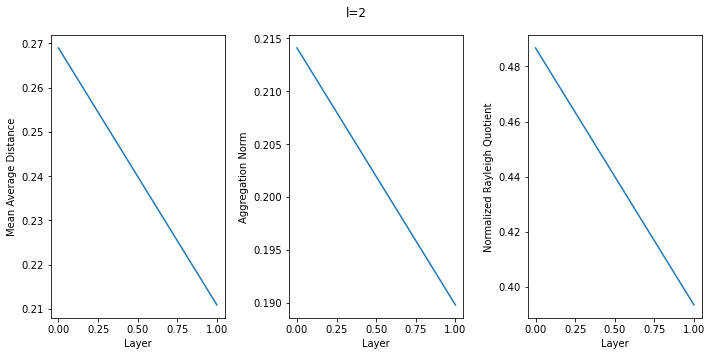

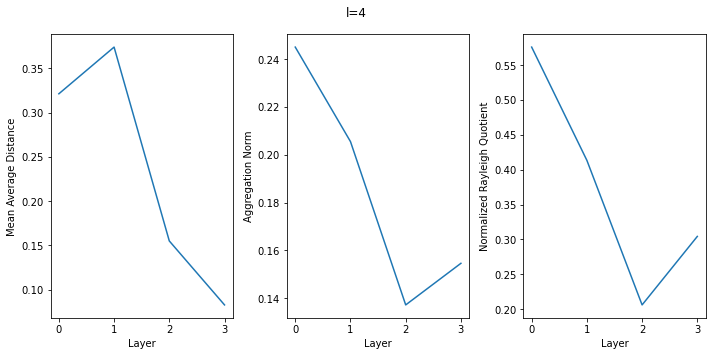

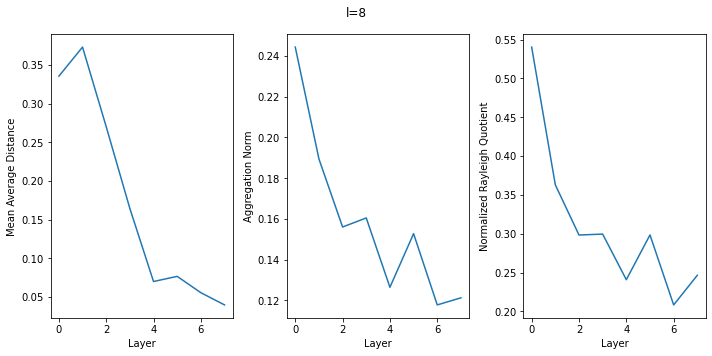

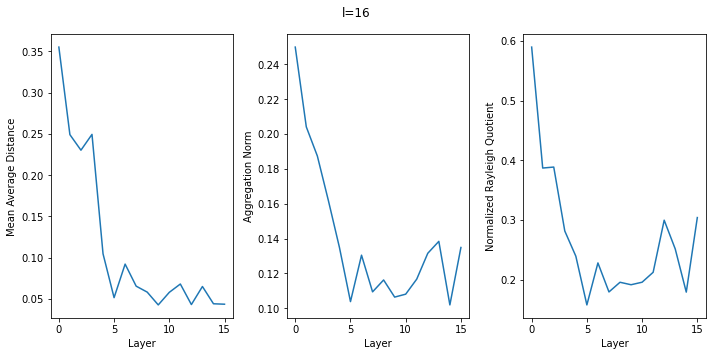

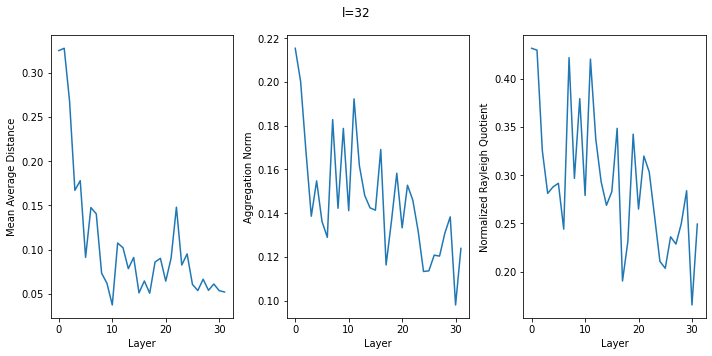

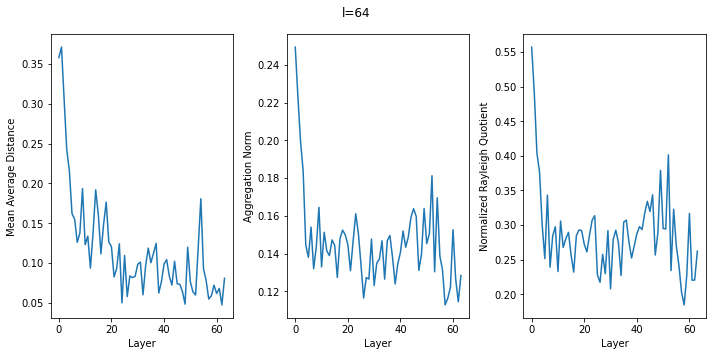

In [28]:
for idx,l in enumerate([2,4,8,16,32,64]):
  plt.figure(figsize=(10,5))

  plt.subplot(1,3,1)
  plt.plot(model_mad[idx+1],label='MAD')
  plt.xlabel('Layer')
  plt.ylabel('Mean Average Distance')

  plt.subplot(1,3,2)
  plt.plot(model_agg[idx+1])
  plt.xlabel('Layer')
  plt.ylabel('Aggregation Norm')

  plt.subplot(1,3,3)
  plt.plot(model_rayleigh[idx+1])
  plt.xlabel('Layer')
  plt.ylabel('Normalized Rayleigh Quotient')
    
  plt.suptitle("l={}".format(l))
  plt.tight_layout()
  plt.show()


In the above figure, we observe an initial decline in MAD, AggNorm, and Rayleigh followed by oscillations in the deeper layers. The range of values does not change much from $l=8$ onwards, which, taken all together, indicates oversmoothing. However, we do not wish to eliminate this smoothing entirely. The relationship between $\vec{d}_{Katz}$ and $\vec{v}_{1}$ has been previously established; the fact that deeper models offer some improvement (and generally drive the Rayleigh Quotient down) suggests that our GCNs are attempting learning something close to, but not exactly, $v_{1}$. 